In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import sys

%matplotlib inline
plt.rcParams['figure.figsize']=[20.,10.]
plt.rcParams['font.size'] = 20

In [27]:
lammps_data_sections = set(['Atoms',
                            'Masses',
                            'Bonds',
                            'Bond Coeffs',
                            'Angles',
                            'Angle Coeffs',
                            'Dihedrals',
                            'Dihedral Coeffs',
                            'Impropers',
                            'Improper Coeffs',
                            'BondBond Coeffs',          # class2 angles
                            'BondAngle Coeffs',         # class2 angles
                            'MiddleBondTorsion Coeffs', # class2 dihedrals
                            'EndBondTorsion Coeffs',    # class2 dihedrals
                            'AngleTorsion Coeffs',      # class2 dihedrals
                            'AngleAngleTorsion Coeffs', # class2 dihedrals
                            'BondBond13 Coeffs',        # class2 dihedrals
                            'AngleAngle Coeffs',        # class2 impropers
                            'Angles By Type',   # new. not standard LAMMPS
                            'Dihedrals By Type',# new. not standard LAMMPS
                            'Angles By Type'])   # new. not standard LAMMPS

def ExtractDataSection(f,
                       section_header, 
                       comment_char = '#',
                       include_header = False,
                       return_line_nums = False):
    inside_section = False
    nonblank_encountered = False
    i = 0
    for line_orig in f:
        return_this_line = False
        line = line_orig.strip()
        if line == section_header:
            inside_section = True
            nonblank_encountered = False
            if include_header:
                return_this_line = True
        # A block of blank lines (which dont immediately follow
        # the section header-name) signal the end of a section:
        elif len(line) == 0:
            if inside_section and include_header:
                return_this_line = True
            if nonblank_encountered:
                inside_section = False
        elif line[0] != comment_char:
            if inside_section:
                nonblank_encountered = True
                return_this_line = True

        if return_this_line:
            if return_line_nums:
                yield i
            else:
                yield line_orig
            
        i += 1


def FindDataSection(f,
                    section_header, 
                    comment_char = '#'):
    i_section_start = -1
    i_section_stop = -1
    inside_section = False
    nonblank_encountered = False
    i = 0
    for line_orig in f:
        line = line_orig.strip()
        if line == section_header:
            inside_section = True
            nonblank_encountered = False
        # A block of blank lines (which dont immediately follow
        # the section header-name) signal the end of a section:
        elif len(line) == 0:
            if nonblank_encountered:
                inside_section = False
                i_section_stop = i
                break
        elif line[0] != comment_char:
            if inside_section:
                if not nonblank_encountered:
                    i_section_start = i # <- first non-blank line
                nonblank_encountered = True
        i += 1

    if i_section_stop == -1:
        if i_section_start != -1:
            i_section_stop = i

    return (i_section_start, i_section_stop)


In [31]:
lines = open('728_1.lammps05', 'r')
section_names=["Bonds"]
fbonds=[]
for section_name in section_names:
    for line in ExtractDataSection(lines, section_name):
        fbonds.append(line)

In [32]:
# fbonds = open('bonds.dat', 'r')  #<--contains only the Bonds section
G=nx.Graph()

In [33]:
## Loading the Graph
for line in fbonds:
#     print(line)
    tokens=line.strip().split()
#     print(tokens)
    if len(tokens) == 0:
        continue
    # The bond-type is in column 2.
    bondtype = int(tokens[1])
    # The atom-IDs are in columns 3 and 4.
    atomid1 = int(tokens[2])
    atomid2 = int(tokens[3])
    G.add_edge(atomid1, atomid2, type=bondtype)

    # ...or just use "G.add_edge(atomid1, atomid2)"
    # if you don't care bout bond type
    # (If multiple bonds connect same pair, try using
    #  MultiDiGraph instead of DiGraph. Hopefully not.)

In [34]:
graph_cycles = nx.cycle_basis(G)
df=pd.DataFrame(columns=['natoms'])
varr = []
for i in range(len(graph_cycles)):
    varr.append(len(graph_cycles[i]))
#     print(len(graph_cycles[i]))

print(len(varr))
df['natoms'] = varr

1641


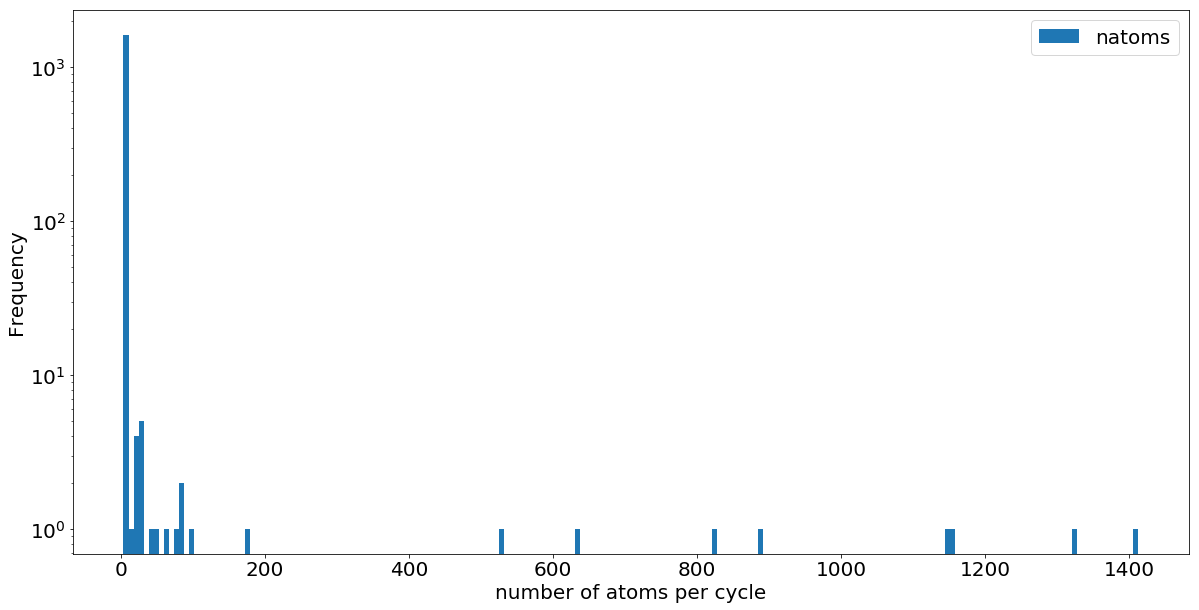

In [35]:
fig, ax = plt.subplots()
df.plot.hist(ax=ax,stacked=True, bins=200)
ax.set_yscale('log')
ax.set_xlabel('number of atoms per cycle')